# various imports

In [3]:
from pprint import pprint

import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt


import prepare as pr 
import re 

from sklearn.model_selection import train_test_split
import sklearn.model_selection
import sklearn.preprocessing


import xgboost as xgb
from sklearn.metrics import confusion_matrix
# from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import  ConfusionMatrixDisplay
from sklearn.metrics import recall_score


from sklearn.feature_extraction.text import CountVectorizer
import sklearn.metrics as m
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
from sklearn.metrics import f1_score

In [4]:
# read in all books to model on
df = pr.prep_data('all_books.csv')

In [5]:
# create a copy of the un-altered df
save = df.copy()

In [6]:
# df = save 

# create dummies

In [ ]:
# creating encode variables

In [7]:
def ready_df(df):
    
    # drop columns we do not want to model on
    df = df.drop(columns= ['title','summary','year_published','author','reviews','cleaned_title','cleaned_summary'])
    
    # creating dummies for genre and sentient
    df['genre'] = df.genre.astype('object')
    dummy_df = pd.get_dummies(df[['genre','sentiment']], dummy_na=False, drop_first=[True, True])
    
    # add dummies to dataframe 
    df = pd.concat([df, dummy_df],axis= 1)
    
    return df
    

In [8]:
# run function
df = ready_df(df)

# split

In [ ]:
# function to split

In [33]:
def split(df, target):
    train, test = train_test_split(df, test_size=.2, random_state=42, stratify=df[target])
    return train, test

In [34]:
# run
train, test = split(df,'successful')

In [ ]:
# create x and y split function

In [35]:
def Xandy_set(train,test):
    
    # creating train and test (x and y) subsets
    X_train =  train.drop(columns= "successful")
    y_train = train['successful']
    
    # creating train and test (x and y) subsets
    X_test = test.drop(columns= "successful")
    y_test = test['successful']
    
    # reset index, (no sorting or reordering)
    X_train = X_train.reset_index(drop= True)
    y_train = y_train.reset_index(drop= True)
    X_test = X_test.reset_index(drop= True)
    y_test = y_test.reset_index(drop= True)
    
    return X_train, y_train, X_test, y_test
    

In [36]:
# run function
X_train, y_train, X_test, y_test = Xandy_set(train,test)

In [ ]:
# create scaling function

In [37]:

def scaling(X_train, X_test):
    
    # create a subset of numerical column
    xtrainnums = X_train[['review_count','number_of_ratings','length','rating']]
    
    number_list = ['review_count','number_of_ratings','length','rating']

    # Note that we only call .fit with the training data
    scaler = sklearn.preprocessing.StandardScaler()
    
    # fit training data to scaler, not transforming here
    scaler.fit(xtrainnums)
    
    # transform the numerical values that we want based on the trained fit scaler
    X_train_scaled = scaler.transform(X_train[number_list])
    X_test_scaled = scaler.transform(X_test[number_list])
    
    # create a dataframe
    X_train_scaled = pd.DataFrame(X_train_scaled, columns= [number_list])
    X_test_scaled = pd.DataFrame(X_test_scaled, columns= [number_list])
    
    
    # add the 'neg','neutral','pos','compound' from x_train to the scaled data. reset
    X_train_scaled[['neg','neutral','pos','compound']] = X_train[['neg','neutral','pos','compound']].reset_index(drop = True)
    X_test_scaled[['neg','neutral','pos','compound']] = X_test[['neg','neutral','pos','compound']].reset_index(drop = True)

    # create a list of the dummies 
    dummies = X_train.columns.tolist()[11:]
    
    # add dummies to dataframe
    X_train_scaled = pd.concat([X_train_scaled, X_train[dummies]],axis = 1 )
    X_test_scaled = pd.concat([X_test_scaled, X_test[dummies]],axis = 1 )


    
    
    return X_train_scaled, X_test_scaled
    

In [38]:
# run
X_train_scaled, X_test_scaled = scaling(X_train, X_test)

# Baseline

In [ ]:
# determine a baseline

In [14]:
y_train = pd.DataFrame(y_train)

In [15]:
y_test = pd.DataFrame(y_test)

In [16]:
y_train['baseline'] = False

In [17]:
y_test['baseline'] = False

# Baseline 

In [ ]:
# visualize the baseline

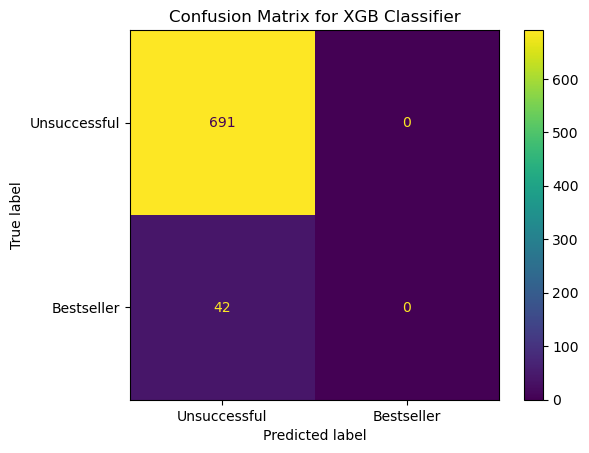

In [18]:
cm = confusion_matrix(y_test['successful'], y_test['baseline'])

    # plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['Unsuccessful', 'Bestseller'])
disp.plot()
disp.ax_.set_title("Confusion Matrix for XGB Classifier")

plt.show()
    

In [19]:
# 0% Recall
# 95% accuracy

# XGBoost Model

In [20]:
def XGBclf(X_train_scaled, X_test_scaled): 
    
    # create  an instance with predetermined values, using cross validation, grid search and other methods,
    # these parameters have been predetermined for the top performance. 
    xgb_clf = xgb.XGBClassifier(objective ='binary:logistic', 
                                        seed = 42,
                                        max_depth = 3,    
                                        scale_pos_weight= 7,
                                        learning_rate = .1,
                                        subsample = .7,
                                        colsample_bytree = .7,
                                        n_jobs = 10)
    
    most_imp = [('number_of_ratings',),
                'genre_Mystery',
                ('review_count',),
                 'genre_Nonfiction',
                'genre_Horror',
                 ('length',),
                 'genre_Fiction',
                 ('rating',),
                 'sentiment_very negative',
                 'genre_Young Adult',
                 'genre_Fantasy',
                 'genre_Romance',
                 ('neutral',),
                 ('neg',),
                 ('pos',),
                 ('compound',),
                 'sentiment_very positive',
                 'genre_Thriller']
    
    # fit the model with x_train, using the most important features, and y_train
    xgb_clf.fit(X_train_scaled[most_imp],y_train['successful'])
    
    # y predictions for test
    y_pred = xgb_clf.predict(X_test_scaled[most_imp])
    
    # assume y_test and y_pred are your test set target variable and predicted labels, respectively
    cm = confusion_matrix(y_test['successful'], y_pred)

    # plot confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['Unsuccessful', 'Bestseller'])
    disp.plot()
    disp.ax_.set_title("Confusion Matrix for XGB Classifier")

    plt.show()
    
    return y_pred
    
    

/usr/local/anaconda3/lib/python3.9/site-packages/pandas/core/common.py:241: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = np.asarray(values, dtype=dtype)
/usr/local/anaconda3/lib/python3.9/site-packages/pandas/core/common.py:241: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = np.asarray(values, dtype=dtype)


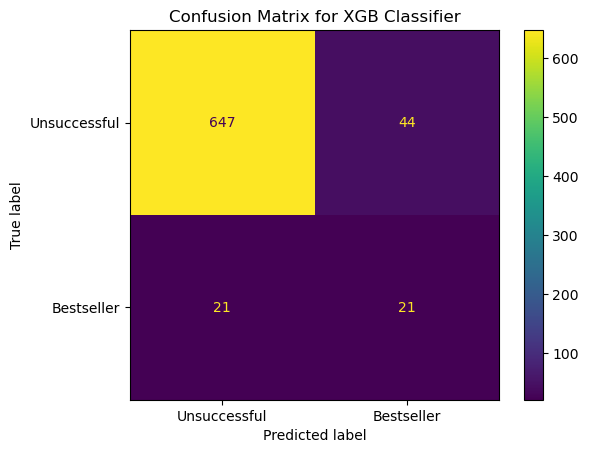

In [21]:
y_pred = XGBclf(X_train_scaled, X_test_scaled) 

# Ensemble Imbalance

In [43]:
import imbalanced_ensemble 

In [9]:
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_classification
from sklearn.metrics import f1_score, make_scorer, confusion_matrix


In [ ]:
# Define parameter grid
param_grid = {
    'base_estimator': ['DecisionTreeClassifier', 'RandomForestClassifier'],
    'n_estimators': [50, 100, 200],
    'sps_step': [0.1, 0.2, 0.3],
    'sps_max_iter': [5, 10, 15],
}

# Define scoring metric
scorer = make_scorer(f1_score, pos_label=1)

# Create grid search object
clf = SelfPacedEnsembleClassifier()
grid_search = GridSearchCV(clf, param_grid, scoring=scorer)

# Fit grid search to data
grid_search.fit(X, y)

# Print best parameters and score
print('Best parameters:', grid_search.best_params_)
print('Best score:', grid_search.best_score_)

# Get best estimator from grid search
best_estimator = grid_search.best_estimator_

# Predict labels using best estimator
y_pred = best_estimator.predict(X)

# Print confusion matrix
print('Confusion matrix:')
print(confusion_matrix(y, y_pred))

# Ensemble Imbalance

# XGBOOST 

# Random Forest

# grid search

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [ ]:
 most_imp = [('number_of_ratings',),
                'genre_Mystery',
                ('review_count',),
                 'genre_Nonfiction',
                'genre_Horror',
                 ('length',),
                 'genre_Fiction',
                 ('rating',),
                 'sentiment_very negative',
                 'genre_Young Adult',
                 'genre_Fantasy',
                 'genre_Romance',
                 ('neutral',),
                 ('neg',),
                 ('pos',),
                 ('compound',),
                 'sentiment_very positive',
                 'genre_Thriller']

In [ ]:
# Create a random forest classifier
rfc = RandomForestClassifier()

# Define the parameter grid to search over
param_grid = {
    'n_estimators': [10, 50, 100],
    'max_depth': [None, 5, 10],
    'max_features': ['auto', 'sqrt'],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create a grid search object
grid_search = GridSearchCV(
    estimator=rfc,
    param_grid=param_grid,
    cv=2,
    n_jobs=-1,
    scoring='accuracy'
)

# Fit the grid search to the data
grid_search.fit(X_train_scaled[most_imp], y_train['successful'])

# Print the best parameters and score
print("Best parameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)


In [ ]:
rfc = RandomForestClassifier(max_depth = None, 
                       max_features= 'sqrt',
                       min_samples_leaf = 1,
                       min_samples_split = 5,
                       n_estimators = 100)

In [ ]:
rfc.fit(X_train_scaled[most_imp], y_train['successful'])

In [ ]:
# y predictions for test
y_pred_rfc = rfc.predict(X_test_scaled[most_imp])
    

In [ ]:
# assume y_test and y_pred are your test set target variable and predicted labels, respectively
cm = confusion_matrix(y_test['successful'], y_pred_rfc)

# plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['Unsuccessful', 'Bestseller'])
disp.plot()
disp.ax_.set_title("Confusion Matrix for XGB Classifier")

# grid search

# Random Forest

# Decision Tree 

# grid search

In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
# Create a random forest classifier
dtc = DecisionTreeClassifier()

# Define the parameter grid to search over
param_grid = {
    'criterion': ['entrop','gini'],
    'max_features': [None, 3,5],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'min_weight_fraction_leaf' : [0.0,0.3,0.5]
}

    
# Create a grid search object
grid_search = GridSearchCV(
    estimator=dtc,
    param_grid=param_grid,
    cv=2,
    n_jobs=-1,
    scoring='recall'
)

# Fit the grid search to the data
grid_search.fit(X_train_scaled[most_imp], y_train['successful'])

# Print the best parameters and score
print("Best parameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)


# grid search

In [ ]:
dtc = DecisionTreeClassifier(criterion= 'gini', 
                       max_depth = None,
                       min_samples_leaf = 1,
                       min_samples_split = 2,
                       min_weight_fraction_leaf= 0.0,
                       max_features= None)

In [ ]:
dtc.fit(X_train_scaled[most_imp], y_train['successful'])

In [ ]:
# y predictions for test
y_pred_dtc = dtc.predict(X_test_scaled[most_imp])

In [ ]:
# assume y_test and y_pred are your test set target variable and predicted labels, respectively
cm = confusion_matrix(y_test['successful'], y_pred_dtc)

# plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['Unsuccessful', 'Bestseller'])
disp.plot()
disp.ax_.set_title("Confusion Matrix for XGB Classifier")

In [ ]:
# Accuracy 92% 
# Recall 31%

# Decision Tree

# final model 

<div class="alert alert-block alert-success">
<b>XGBOOST:</b> 
# accuracy 91.13%
# recall 50%
</div>

<div class="alert alert-block alert-success">
<b>RandomForest:</b> 
# accuracy 94%
# recall 4%
</div>

<div class="alert alert-block alert-success">
<b>DecisionTree:</b> 
# accuracy 95%
# recall 28%
</div>

<div class="alert alert-block alert-success">
<b>Baseline:</b> 
# accuracy 99%
# recall 0%
</div>




In [ ]:
import seaborn as sns

models = {'Accuracy': [91.13, 94, 95, 99],
          'Recall' : [50, 4, 28, 0]}
index = ['XGBoost', 'RandomForest', 'DecisionTree', 'Baseline']

model_profit = pd.DataFrame(models, index=index)

In [ ]:
model_profit = model_profit.T

In [ ]:
model_profit['metric'] = model_profit['metric'].astype('string')

In [ ]:
model_profit['metric'][0] = model_profit['metric'][0].replace('0','acc')

In [ ]:
model_profit['metric'][1] = model_profit['metric'][1].replace('0','rec')

In [ ]:
model_profit

In [ ]:
data = pd.DataFrame({
    'Model': ['XGBoost', 'RandomForest', 'DecisionTree', 'Baseline'],
    'Accuracy': [91.13, 94.0, 95.0, 99.0],
    'Recall': [50.00, 4.0, 28.0, 0.0],
    
})


In [ ]:
data

In [ ]:
# Melt the DataFrame to "long" format
data_melted = pd.melt(data, id_vars=['Model'], var_name='Metric', value_name='Value')

In [ ]:
data_melted = data_melted.sort_values(by = "Value")

In [ ]:
data_melted

In [ ]:
0E3AFA
68fd7f

In [ ]:
color1 = '#68FD7F'
color2 = '#0E3AFA'  
sns.set_style('whitegrid')

In [ ]:
# Plot the data
ax =sns.barplot(x='Model', y='Value', hue='Metric', data=data_melted, palette=[color1, color2])
sns.move_legend(ax, "upper left")

plt.title('Model Performance')
plt.xlabel('Model Types')
plt.ylabel('Percentage')



In [ ]:
sns.barplot(x = 'Model',y = 'Accuracy' ,data= data)

In [ ]:
# Plot the data
sns.barplot(x='Model', y='value', hue='', data=pd.melt(data, id_vars=['Model'], value_vars=['Accuracy', 'Recall']), palette={'acc': 'red', 'rec': 'blue'})

# roc chart

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc 

In [ ]:
mode_val = y_test['successful'].mode()[0]

# Create a new column with the mode value
y_test = y_test.assign(baseline=mode_val)

In [ ]:
y_test['baseline']

In [ ]:
def roc(y_test, y_pred):
    
    
    mode_val = y_test['successful'].mode()[0]

    # Create a new column with the mode value
    y_test = y_test.assign(baseline=mode_val)
    
    
    plt.figure(figsize=(10,6))


    fpr, tpr, thresholds = roc_curve(y_test['successful'], y_pred)
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'XGBClassifer (area = %0.4f)' % auc(fpr, tpr))

    fpr, tpr, thresholds = roc_curve(y_test['successful'], y_test['baseline'])
    plt.plot(fpr, tpr, color='red', lw=2, label=f'Baseline (area = %0.4f)' % auc(fpr, tpr))


    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate', fontsize=13)
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.title('XGB Classifier Captured Area', fontsize=17)
    plt.legend(loc='lower right', fontsize=13)
    plt.show()

In [ ]:
roc(y_test, y_pred)

In [ ]:
# from sklearn.metrics import make_scorer, recall_score

In [ ]:
def th_hyperparam_tuning(x_train, y_train, x_test, y_test, max_depths, scale_pos_weights, learning_rates, subsamples, colsample_bytrees):
    for max_depth in max_depths:
        for scale_pos_weight in scale_pos_weights:
            for learning_rate in learning_rates:
                for subsample in subsamples:
                    for colsample_bytree in colsample_bytrees:
                        # define the XGBClassifier with the current hyperparameters
                        xgb_model = xgb.XGBClassifier(objective ='binary:logistic', 
                                                  seed=42,
                                                  max_depth=max_depth,
                                                  scale_pos_weight=scale_pos_weight,
                                                  learning_rate=learning_rate,
                                                  subsample=subsample,
                                                  colsample_bytree=colsample_bytree,
                                                  n_jobs=10)
                        # fit the model on the training set
                        xgb_model.fit(x_train, y_train)
                        # predict on the test set
                        y_pred = xgb_model.predict(x_test)
                        # print the hyperparameters and the resulting f1-score
                        print(f"max_depth={max_depth}, scale_pos_weight={scale_pos_weight}, learning_rate={learning_rate}, subsample={subsample}, colsample_bytree={colsample_bytree}: f1-score={f1_score(y_test, y_pred)},: recall-score={recall_score(y_test, y_pred)}")
                        print('\n')
                        # print the confusion matrix
                        print(confusion_matrix(y_test, y_pred))
                        print('\n')
                        

In [ ]:
max_depths = [3, 5, 7]
scale_pos_weights = [3, 5, 7]
learning_rates = [0.01, 0.1, 1]
subsamples = [0.7, 0.8, 0.9]
colsample_bytrees = [0.5, 0.6, 0.7]

In [ ]:
# calling function
th_hyperparam_tuning(X_train_scaled[most_imp], y_train, X_test_scaled[most_imp], y_test, max_depths, scale_pos_weights, learning_rates, subsamples, colsample_bytrees)


In [ ]:
# create an instance with predetermined values 
clf_xgb = xgb.XGBClassifier(objective ='binary:logistic', 
                                        seed = 42,
                                        max_depth = 3,    
                                        scale_pos_weight= 5,
                                        learning_rate = .01,
                                        subsample = .9,
                                        colsample_bytree = .5,
                                        n_jobs = 10)

In [ ]:
clf_xgb.fit(X_train_scaled,y_train)

In [ ]:
clf_xgb.feature_importances_

In [ ]:
most_imp = feat_importances.nlargest(18).index.tolist()

In [ ]:
most_imp = [('number_of_ratings',),
 'genre_Mystery',
 ('review_count',),
 'genre_Nonfiction',
 'genre_Horror',
 ('length',),
 'genre_Fiction',
 ('rating',),
 'sentiment_very negative',
 'genre_Young Adult',
 'genre_Fantasy',
 'genre_Romance',
 ('neutral',),
 ('neg',),
 ('pos',),
 ('compound',),
 'sentiment_very positive',
 'genre_Thriller']

In [ ]:
feat_importances = pd.Series(clf_xgb.feature_importances_, index= x_train_scaled.columns)
feat_importances.nlargest(18).plot(kind='barh')
plt.title("Top 18 important features")
plt.show()


In [ ]:
x_train_scaled[important_feats]